# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, … Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

In [1]:
import folium
import pandas as pd
import numpy as np
import json
import re

We import data from the eurostat website.
It contains yearly unemploiment data for EU countries. Data for Switzerland is not included.

In [2]:
data = pd.read_csv("data/lfsq_urgan_1_Data.csv", sep=",")

In [3]:
data.head()

,TIME,GEO,SEX,AGE,CITIZEN,UNIT,Value
0,2015Q1,European Union (28 countries),Total,From 15 to 74 years,Total,Percentage,10.2
1,2015Q2,European Union (28 countries),Total,From 15 to 74 years,Total,Percentage,9.5
2,2015Q3,European Union (28 countries),Total,From 15 to 74 years,Total,Percentage,9.0
3,2015Q4,European Union (28 countries),Total,From 15 to 74 years,Total,Percentage,9.1
4,2016Q1,European Union (28 countries),Total,From 15 to 74 years,Total,Percentage,9.2


In [4]:
# we only want to use the latest information
# so we use only the rows where time is "2017Q2"
time_filter = data.iloc[:,0]=="2017Q2"
latest_data = data[time_filter]

# there are some aggregate rows with information on the entire EU
# we only want individual countries
name_filter = latest_data.iloc[:,1].apply(lambda x : "euro" not in x.lower())
latest_data = latest_data[name_filter]
latest_data.head()

,TIME,GEO,SEX,AGE,CITIZEN,UNIT,Value
69,2017Q2,Belgium,Total,From 15 to 74 years,Total,Percentage,7.0
79,2017Q2,Bulgaria,Total,From 15 to 74 years,Total,Percentage,6.3
89,2017Q2,Czech Republic,Total,From 15 to 74 years,Total,Percentage,3.0
99,2017Q2,Denmark,Total,From 15 to 74 years,Total,Percentage,5.5
109,2017Q2,Germany (until 1990 former territory of the FRG),Total,From 15 to 74 years,Total,Percentage,3.8


In [5]:
# The GEO column only contains unique elements
latest_data.set_index("GEO").index.is_unique

True

In order to display this as a map, we need to transform the country names into country codes.
For example, Switzerland needs to become CH.

Information on country codes can also be found on the eurostat website.
We have downloaded and cleaned this data.
A remaining problem is that some country names are composed of more than just one word.

In [6]:
names = pd.read_csv("data/country_codes.txt", header=None)
names.columns=["country_name", "country_code"]
names.head()

,country_name,country_code
0,Belgium,BE
1,Greece,EL
2,Lithuania,LT
3,Portugal,PT
4,Bulgaria,BG


In [7]:
# two entries are problematic:
# Germany and Macedonia
# in order to merge the two dataframes, we create a new column for merging
latest_data["on_merge"] = latest_data["GEO"]
names["on_merge"] = names["country_name"]

print("name of Germany in dataframe: ", latest_data["on_merge"][109])
latest_data["on_merge"][109] = "Germany"

print("name of Macedonia in dataframe: ", latest_data["on_merge"][379])
latest_data["on_merge"][379] = "Macedonia"

print("name of Macedonia in names: ", names["on_merge"][33])
names["on_merge"][33] = "Macedonia"

name of Germany in dataframe:  Germany (until 1990 former territory of the FRG)
name of Macedonia in dataframe:  Former Yugoslav Republic of Macedonia, the
name of Macedonia in names:  The former Yugoslav Republic of Macedonia


C:\Users\lhk\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lhk\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# now we can just merge the dataframes
merged = latest_data.merge(names, left_on="on_merge", right_on="on_merge")
merged.head()

,TIME,GEO,SEX,AGE,CITIZEN,UNIT,Value,on_merge,country_name,country_code
0,2017Q2,Belgium,Total,From 15 to 74 years,Total,Percentage,7.0,Belgium,Belgium,BE
1,2017Q2,Bulgaria,Total,From 15 to 74 years,Total,Percentage,6.3,Bulgaria,Bulgaria,BG
2,2017Q2,Czech Republic,Total,From 15 to 74 years,Total,Percentage,3.0,Czech Republic,Czech Republic,CZ
3,2017Q2,Denmark,Total,From 15 to 74 years,Total,Percentage,5.5,Denmark,Denmark,DK
4,2017Q2,Germany (until 1990 former territory of the FRG),Total,From 15 to 74 years,Total,Percentage,3.8,Germany,Germany,DE


In [9]:
# for the map, we only need the code and the percentage
to_plot = merged[["Value","country_name"]]
to_plot.head()

,Value,country_name
0,7.0,Belgium
1,6.3,Bulgaria
2,3.0,Czech Republic
3,5.5,Denmark
4,3.8,Germany


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
sorted_plot = to_plot.sort_values("Value")
sorted_plot.head()

,Value,country_name
2,3.0,Czech Republic
28,3.4,Iceland
4,3.8,Germany
17,4.1,Malta
27,4.3,United Kingdom


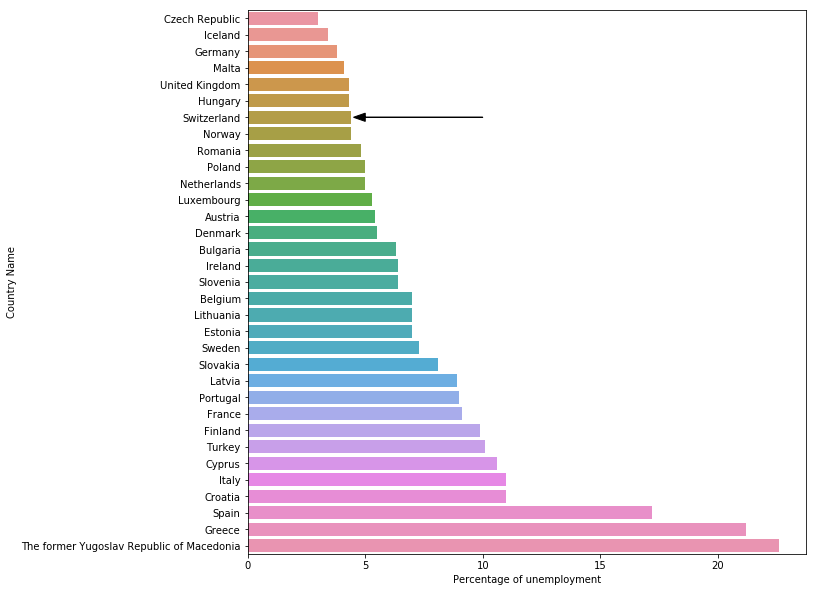

In [12]:
ax = plt.figure(figsize=(10,10))
ax = sns.barplot(x=sorted_plot["Value"], y=sorted_plot["country_name"])
ax.set(ylabel='Country Name', xlabel='Percentage of unemployment')

ax.arrow(10, 6, -5, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
plt.show()

This bar plot is hard to interpret. The outliers have a strong effect on the scaling.

We use a bar plot to get intuition for the distribution of the data. Then we use the built-in describe method to see the corresponding values

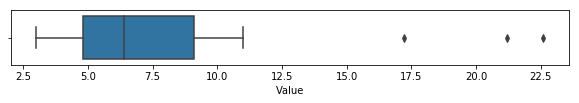

In [13]:
ax = plt.figure(figsize=(10,1))

sns.boxplot(sorted_plot["Value"])
plt.show()

In [14]:
to_plot.describe()

,Value
count,33.000000
mean,7.842424
std,4.675002
min,3.000000
25%,4.800000
50%,6.400000
75%,9.100000
max,22.600000


The minimum and maximum are quite far apart. We create a new barplot and only include values that are below the 75% quantile. This should allow for a more intuitive comparison

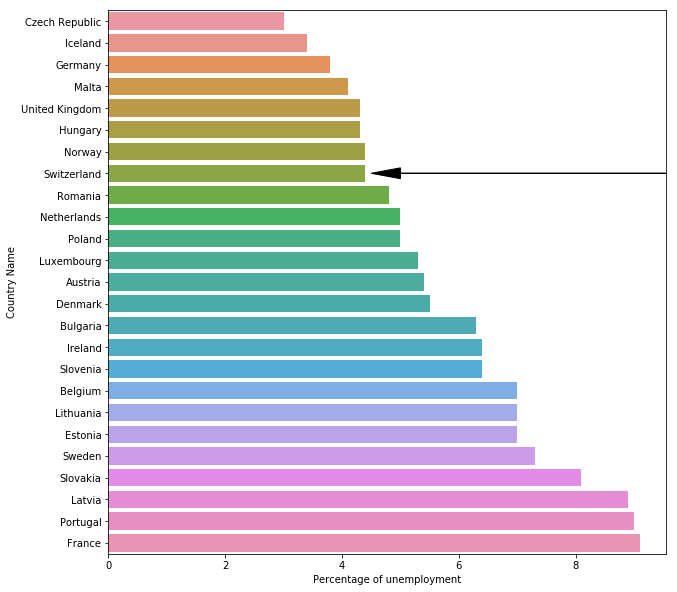

In [15]:
within_quantiles = to_plot.query("3<=Value<=9.1")
within_quantiles = within_quantiles.sort_values("Value")

ax = plt.figure(figsize=(10,10))
ax = sns.barplot(x=within_quantiles["Value"], y=within_quantiles["country_name"])
ax.set(ylabel='Country Name', xlabel='Percentage of unemployment')

ax.arrow(10, 7, -5, 0, head_width=0.5, head_length=0.5, fc='k', ec='k')
plt.show()

## Visualizing the unemployment on a map of Europe

The branca package provides a variety of different colorscales.
We used this http://colorbrewer2.org/#type=sequential&scheme=PuRd&n=3 website to compare different colorschemes.

We only included "colorblind-safe" colorschemes.
This still allows for a wide range of colormaps.

Choosing appropriate colors is a sensitive topic since people have instinctive assotiations with colors.
If we would, for example, plot the distribution of agreement with a specific thesis on a map, we would have to be careful not to discriminate some points of view.

In this case, we have just one scalar value, which is arguably rather negative. Therefore we decided to use a "red" colorscale. Intense hues of red correspond to high levels of unemployment. This intuitively conveys a negative impression.

We also scale our colormap from our min to max values.
Some countries are not available in the eurostat dataset. We color them in black.

In [16]:
import branca

In [17]:
min_value = 3
max_value = 22.6
colorscale = branca.colormap.linear.PuRd.scale(min_value, max_value)

def scaled_style(feature):
    # extract the country name
    name = feature["properties"]["NAME"]
    
    # get the corresponding entry in the plot dataframe
    entry = to_plot.loc[to_plot["country_name"]==name]
    
    # check whether the entry exists, extract the value if yes
    if entry.shape[0] == 0:
        value = None
    else:
        value = entry["Value"].iloc[0]
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if value is None else colorscale(value)
    }
coordinates = [54.5260, 15.2551]


geo_europe_json = r'topojson/europe.topojson.json'
geo_europe = json.load(open(geo_europe_json))



m = folium.Map(
    location=coordinates,
    tiles='cartodbpositron',
    zoom_start=3)


folium.TopoJson(
    geo_europe,
    'objects.europe',
    style_function=scaled_style
).add_to(m)

colorscale.caption = 'Rate of unemployment (%)'
m.add_child(colorscale)

## Comparing Switzerland to other European countries

Above, we have already used barplots to compare Switzerland with other European countries.
Now we would like to show on a map or Europe, how Switzerland compares against other countries.

The color codes in a map don't convey precise information and can only show a trend. We will therefore only show which countries have higher and which have lower unemployment rates.
Again, we use the website http://colorbrewer2.org/#type=sequential&scheme=YlGnBu&n=3 and select a colorscheme. Countries with the same level of unemployment are green, countries with lesser unemployment are yellow and countries with higher unemployment are a dark blue.

In [18]:
swiss_value =  to_plot.loc[to_plot["country_name"]=="Switzerland"]["Value"].iloc[0]
swiss_value

4.4000000000000004

In [19]:
colorscale = branca.colormap.linear.YlGnBu.scale(0, 2)

def map_color(value):
    if value == 2:
        return "#2c7fb8"
    elif value==1:
        return "#7fcdbb"
    return "#edf8b1"

def comparison_style(feature):
    # extract the country name
    name = feature["properties"]["NAME"]
    
    # get the corresponding entry in the plot dataframe
    entry = to_plot.loc[to_plot["country_name"]==name]
    
    # check whether the entry exists, extract the value if yes
    if entry.shape[0] == 0:
        value = None
    else:
        value = entry["Value"].iloc[0]
        if value > swiss_value:
            value = 2
        elif value==swiss_value:
            value = 1
        else:
            value = 0
        
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#black' if value is None else map_color(value)
    }
coordinates = [54.5260, 15.2551]


geo_europe_json = r'topojson/europe.topojson.json'
geo_europe = json.load(open(geo_europe_json))



m = folium.Map(
    location=coordinates,
    tiles='cartodbpositron',
    zoom_start=3)


folium.TopoJson(
    geo_europe,
    'objects.europe',
    style_function=comparison_style
).add_to(m)


colorscale.caption = 'Discrete colors, relative to Switzerland: 0 = lower, 1 = equal, 2 = higher'
m.add_child(colorscale)